In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from google.colab import drive
import os
import pickle
from scipy.signal import find_peaks, argrelextrema
from scipy.spatial.distance import cdist
lab_size = 15
plt.rcParams.update({
    'font.size': lab_size,
    'font.family': 'Times New Roman',
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}'  # Load amsmath package
})

In [ ]:
def time_ts(natural_time):
        return int(natural_time/0.01)

In [ ]:
spectral_radii = np.linspace(0, 0.8, 17)
spectral_radii = [str(p) for p in spectral_radii]
spectral_radii.append('0.85')
spectral_radii.append('0.90')
spectral_radii.append('0.95')
spectral_radii.append('1.00')
spectral_radii.append('1.05')
spectral_radii.append('1.10')
randMatrices = ['M', 'Win']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def save_dictionary(dictionary, file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(file_path, 'wb') as file:
        pickle.dump(dictionary, file, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'Dictionary saved to {file_path}')

def load_dictionary(file_path):
    with open(file_path, 'rb') as file:
        loaded_dictionary = pickle.load(file)
    print(f"Data loaded successfully from {file_path}")
    return loaded_dictionary

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# this function checks if a trajectory is a fixed point
def is_fixed_point(traj):
    return np.allclose(traj, traj[0], atol=1e-3)

# this trajectory checks if a trajectory represents a limit cycle
def is_limit_cycle(traj):
    local_maxima = []

    # Identify local maxima in the trajectory based on the third dimension (z-coordinate).
    for i in range(1, len(traj) - 1):
        window = traj[i-1:i+2]
        middle_point = traj[i]

        if middle_point[2] == max(window[0][2], window[1][2], window[2][2]):
            local_maxima.append((i, middle_point))

    if len(local_maxima) < 2:
        return False

    # Identify the global maximum and points close to it.
    max_value = float('-inf')
    global_max_index = None
    for index, state in local_maxima:
        if state[2] > max_value:
            max_value = state[2]
            global_max_index = index

    global_max_state = traj[global_max_index]

    # Find all points that are sufficiently close to the global max state
    filtered_maxima_indexes = [pos for pos, state in local_maxima if np.allclose(state, global_max_state, atol=0.11)]

    # If we don't have enough maxima close to the global max, we can't form a cycle
    if len(filtered_maxima_indexes) < 2:
        return False

    # Get differences between the maxima indices
    differences = np.diff(filtered_maxima_indexes)

    # Allow cases with fewer than 3 differences to be valid as not enough timeseries data is present.
    if len(differences) < 3:
        return True

    # Detect periodic pattern in the differences array, allowing for incomplete or constant patterns
    for period_length in range(1, len(differences) // 2 + 1):
        pattern = differences[:period_length]
        repeated_pattern = True

        # Check if the pattern repeats or has a constant distance at the end
        for i in range(period_length, len(differences), period_length):
            remaining_length = len(differences) - i

            # Allow incomplete but matching patterns at the end
            if remaining_length < period_length:
                if not np.array_equal(differences[i:], pattern[:remaining_length]):
                    repeated_pattern = False
                break
            else:
                if not np.array_equal(differences[i:i+period_length], pattern):
                    repeated_pattern = False
                    break

        # Check if the remaining segment has constant distances, i.e., if all differences are equal
        if repeated_pattern:
            return True

    return False

# this checks if a trejactory is in the lorenz shaped box
def is_lorenz_attractor(traj):
    x, y, z = traj[:, 0], traj[:, 1], traj[:, 2]
    total_points = len(traj)
    points_within_bounds = (
        np.sum((x >= -20) & (x <= 20)) +
        np.sum((y >= -30) & (y <= 30)) +
        np.sum((z >= -5) & (z <= 55))
    )
    percentage_within_bounds = points_within_bounds / (3 * total_points)
    return percentage_within_bounds >= 0.975

# this runs through these checks above in order of strictness of the test and returns a classification
def classify_single_trajectory(traj):
    if is_fixed_point(traj):
        return 0
    elif is_limit_cycle(traj):
        return 1
    elif is_lorenz_attractor(traj):
        return 2
    else:
        return 3

# this function takes a full state space exploration (100 trajectories) and classifies each
def classify_attractors(trajectories):
    classifications = [classify_single_trajectory(traj) for traj in trajectories]
    return classifications

# This code below is an exmaple o fthe classification of the trajectories in an exploration

In [ ]:
p = spectral_radii[1]
randMat = randMatrices[0]
p, randMat

('0.05', 'M')

In [ ]:
#file_path = f'drive/My Drive/bifurcation_analysis_data/{p}_{randMat}.pkl'
file_path = f'drive/My Drive/Lorenz_birth_data/0.003_M.pkl'
file_path

'drive/My Drive/Lorenz_birth_data/0.003_M.pkl'

In [ ]:
bifurcation_analysis_loaded = load_dictionary(file_path)

Data loaded successfully from drive/My Drive/Lorenz_birth_data/0.003_M.pkl


In [ ]:
trajectories, _ = bifurcation_analysis_loaded

In [ ]:
trajectory_set_1 = trajectories[17]

<ipython-input-86-d5e236f4dee5>:15: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 15


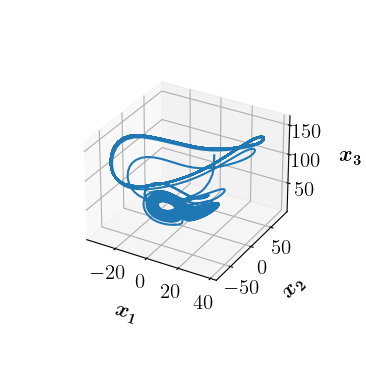

In [ ]:
classifications = classify_attractors(trajectory_set_1[:, time_ts(10):])
classes = ["Fixed Point", "Limit Cycle", "Lorenz Attractor", "Other Attractor"]

num_trajectories = len(trajectory_set_1)
num_cols = 4
num_rows = (num_trajectories + num_cols - 1) // num_cols

fig = plt.figure(figsize=(15, 5 * num_rows))

for i, (traj, cls) in enumerate(zip(trajectory_set_1, classifications)):
    row = i // num_cols
    col = i % num_cols

    ax = fig.add_subplot(num_rows, num_cols, i+1, projection='3d')
    ax.dist = 15
    ax.zaxis.set_rotate_label(False)

    #ax.plot(traj[time_ts(60):, 0], traj[time_ts(60):, 1], traj[time_ts(60):, 2], label=f"{i} : {classes[cls]}")  # this shows only the attractors
    #ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"{i} : {classes[cls]}")           # this shows the behaviour pre attractor
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2])           # this shows the behaviour pre attractor
    ax.set_xlabel(r'$\boldsymbol{x_1}$', size=15, labelpad= 20)
    ax.set_ylabel(r'$\boldsymbol{x_2}$', size=15, labelpad= 20)
    ax.set_zlabel(r'$\boldsymbol{x_3}$', size=15, labelpad = 20, rotation = 0)
    #ax.legend()
plt.tight_layout()
plt.savefig(f'drive/My Drive/thesis_figures/chapter_4/chaotic_transients_test_topology_2.pdf',transparent = True, bbox_inches = 'tight')
plt.show()

In [ ]:
file_path = f'drive/My Drive/bifurcation_analysis_data'
file_path

'drive/My Drive/bifurcation_analysis_data'

# This section details the large scale classification of all the data collected in the simulation generation notebook

In [ ]:
# pass the filepath holding all the data to be classified
file_path = f'drive/My Drive/bifurcation_analysis_data'
#create different data structures to store the classifications of the exploration subject to M and Win
bifurcation_analysis_attractor_data_M = {}
bifurcation_analysis_attractor_data_Win = {}

#attractor_seen_dictionary = {}
for filename in os.listdir(file_path):
        #Extract parameters from filename
        p, randMat = filename.rstrip('.pkl').split('_')

        # Ensure dictionary keys exist with specific initialization
        if p not in bifurcation_analysis_attractor_data_M:
            bifurcation_analysis_attractor_data_M[p] = {}

        if p not in bifurcation_analysis_attractor_data_Win:
            bifurcation_analysis_attractor_data_Win[p] = {}

        # Load data
        full_path = os.path.join(file_path, filename)
        loaded_data_for_analysis = load_dictionary(full_path)
        bundle_of_trajectory_simulations, _ = loaded_data_for_analysis

        #Perform classification
        classifications = [classify_attractors(trajectories[:, time_ts(60):]) for trajectories in bundle_of_trajectory_simulations]

        # Store results
        if randMat == 'M':
            bifurcation_analysis_attractor_data_M[p] = classifications # This would be a list of 50 elements, where each element is a list of 100 elements (each of these elements is a classification)
        elif randMat == 'Win':
            bifurcation_analysis_attractor_data_Win[p] = classifications

print("Bifurcation analysis completed.")

Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.05_Win.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.1_M.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.1_Win.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.15000000000000002_M.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.15000000000000002_Win.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.2_M.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.2_Win.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.25_M.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.25_Win.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.30000000000000004_M.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.30000000000000004_Win.pkl
Data loaded successfully from 

In [ ]:
# given the reduction in space from a full trajectiry to a single integer classification we can now store the entire data in one dictionary as shown here
file_path1 = f'drive/My Drive/bifurcation_analysis_data/classifications_M_dict.pkl'
file_path2 = f'drive/My Drive/bifurcation_analysis_data/classifications_Win_dict.pkl'

save_dictionary(bifurcation_analysis_attractor_data_M, file_path1)
save_dictionary(bifurcation_analysis_attractor_data_Win, file_path2)

Dictionary saved to drive/My Drive/bifurcation_analysis_data/classifications_M_dict.pkl
Dictionary saved to drive/My Drive/bifurcation_analysis_data/classifications_Win_dict.pkl


# This is a test for the different classification of different attractors of the same type

In [ ]:
def global_maxima(traj):
    local_maxima = []
    for i in range(1, len(traj) - 1):
        window = traj[i-1:i+2]
        middle_point = traj[i]
        # Find the local maxima in terms of the third coordinate (z)
        if middle_point[2] == max(window[0][2], window[1][2], window[2][2]):
            local_maxima.append((i, middle_point))

    # Find the global maximum
    max_value = float('-inf')
    global_max_index = None
    for index, state in local_maxima:
        if state[2] > max_value:
            max_value = state[2]
            global_max_index = index

    return traj[global_max_index]

def trim_attractor_trajectories(trajectories):
    classifications = classify_attractors(trajectories[:, time_ts(50):])
    trimmed_attractors_dict = {}

    for i, (cls, traj) in enumerate(zip(classifications, trajectories[:, time_ts(50):])):
        traj_maxima = global_maxima(traj)

        if cls not in trimmed_attractors_dict:
            trimmed_attractors_dict[cls] = [(trajectories[i], traj_maxima, i)]
        elif cls != 2:  # Exclude chaotic attractors
            if all(not np.allclose(traj_maxima, stored_max, atol=1) for _, stored_max, _ in trimmed_attractors_dict[cls]):
                trimmed_attractors_dict[cls].append((trajectories[i], traj_maxima, i))

    return trimmed_attractors_dict

def classify_and_store_attractors(global_attractor_dict, classifications, trajectories):

    results = []

    for cls, traj in zip(classifications, trajectories[:, time_ts(50):]):
        traj_maxima = global_maxima(traj)

        # Check if this attractor class already exists
        if cls not in global_attractor_dict:
            global_attractor_dict[cls] = [(traj, traj_maxima)]  # Add new attractor class
            instance_index = 1
        else:
            found = False
            # Check if this trajectory matches any existing instance
            for instance_id, (_, stored_maxima) in enumerate(global_attractor_dict[cls], 1):
                if np.allclose(traj_maxima, stored_maxima, atol=1):
                    instance_index = instance_id
                    found = True
                    break
            if not found:
                global_attractor_dict[cls].append((traj, traj_maxima))  # New instance of this attractor
                instance_index = len(global_attractor_dict[cls])

        # Store the classification as (class, instance index)
        results.append((cls, instance_index))

    return results

def classification_of_global_attractors(file_path):

    bifurcation_analysis_attractor_data_M = {}
    bifurcation_analysis_attractor_data_Win = {}

    # Global dictionary to store attractors across all simulations
    global_attractor_dict = {}

    for filename in os.listdir(file_path):
        # Extract parameters from filename
        p, randMat = filename.rstrip('.pkl').split('_')

        # Ensure dictionary keys exist with specific initialization
        if p not in bifurcation_analysis_attractor_data_M:
            bifurcation_analysis_attractor_data_M[p] = {}

        if p not in bifurcation_analysis_attractor_data_Win:
            bifurcation_analysis_attractor_data_Win[p] = {}

        # Load data
        full_path = os.path.join(file_path, filename)
        loaded_data_for_analysis = load_dictionary(full_path)
        bundle_of_trajectory_simulations, _ = loaded_data_for_analysis

        # Perform classification and store attractors globally
        for trajectories in bundle_of_trajectory_simulations:
            classifications = classify_attractors(trajectories[:, time_ts(60):])
            classified_results = classify_and_store_attractors(global_attractor_dict, classifications, trajectories)

            # Store results
            if randMat == 'M':
                bifurcation_analysis_attractor_data_M[p] = classified_results
            elif randMat == 'Win':
                bifurcation_analysis_attractor_data_Win[p] = classified_results

    print("Bifurcation analysis completed.")
    return bifurcation_analysis_attractor_data_M, bifurcation_analysis_attractor_data_Win, global_attractor_dict

file_path = 'drive/My Drive/bifurcation_analysis_data'
M_global_dynamics_clas_dict, Win_global_dynamics_clas_dict, global_attractor_dict = classification_of_global_attractors(file_path)

Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.05_Win.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.1_M.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.1_Win.pkl
Data loaded successfully from drive/My Drive/bifurcation_analysis_data/0.15000000000000002_M.pkl


KeyboardInterrupt: 

In [ ]:
file_path1 = f'drive/My Drive/RC_thesis_misc_data/advanced_classifications_M_dict.pkl'
file_path2 = f'drive/My Drive/RC_thesis_misc_data/advanced_classifications_Win_dict.pkl'
file_path3 = f'drive/My Drive/RC_thesis_misc_data/global_attractor_dictionary_used_in_advanced_classifications.pkl'


save_dictionary(M_global_dynamics_clas_dict, file_path1)
save_dictionary(Win_global_dynamics_clas_dict, file_path2)
save_dictionary(global_attractor_dict, file_path3)

# This section details the transformation of the large scale classification dictionary data pulled from the data of the explorations into interpretable graphs

In [ ]:
file_path1 = f'drive/My Drive/RC_thesis_misc_data/classifications_M_dict.pkl'
file_path2 = f'drive/My Drive/RC_thesis_misc_data/classifications_Win_dict.pkl'

In [ ]:
bifurcation_analysis_attractor_data_M = load_dictionary(file_path1)
bifurcation_analysis_attractor_data_Win = load_dictionary(file_path2)

Data loaded successfully from drive/My Drive/RC_thesis_misc_data/classifications_M_dict.pkl
Data loaded successfully from drive/My Drive/RC_thesis_misc_data/classifications_Win_dict.pkl


In [ ]:
# this function takes the set of classifications of trajectories in an exploration and returns a dictionary of how many times each classification is seen
from collections import Counter
def abstracted_categorical_classification(classifications):
    class_counts = dict(Counter(classifications))
    classifications_seen = [key for key in class_counts.keys() if class_counts[key] > 0]
    return sorted(classifications_seen)

In [ ]:
# this cell goes through all classification of trajectories in explorations across rho and the M, Win variant and classifies the entire exploration according to what attractors exist in it.
# this will be represented as a string e.g. FP + LC for an exploration containing only Limit cycles and Fixed points
andrew_classification_counter_dictionary = {}
for p in spectral_radii:
  andrew_classification_counter_dictionary[p] = {}

for p in bifurcation_analysis_attractor_data_M.keys():
  classification_counter = {}
  for classification_by_M in bifurcation_analysis_attractor_data_M[p]:
    classifications_present = abstracted_categorical_classification(classification_by_M)
    attractor_types = ["FP", "LC", "$\hat{\mathcal{L}}$", "OA"]
    classifications_present_as_string = ' + '.join([attractor_types[c] for c in classifications_present])

    if classifications_present_as_string in classification_counter:
        classification_counter[classifications_present_as_string] += 1
    else:
        classification_counter[classifications_present_as_string] = 1
  andrew_classification_counter_dictionary[p] = classification_counter

In [ ]:
# this goes through the dictionary representing the large scale classification of explorations and makes a list of all classifications identified
def extract_unique_keys(dictionary):
    unique_keys = set()
    for inner_dict in dictionary.values():
        unique_keys.update(inner_dict.keys())
    return list(unique_keys)

unique_keys = extract_unique_keys(andrew_classification_counter_dictionary)
unique_keys

['FP + LC + $\\hat{\\mathcal{L}}$',
 'LC + OA',
 'LC + $\\hat{\\mathcal{L}}$',
 'FP',
 'FP + OA',
 'FP + $\\hat{\\mathcal{L}}$',
 'OA',
 'LC + $\\hat{\\mathcal{L}}$ + OA',
 '$\\hat{\\mathcal{L}}$ + OA',
 'FP + LC',
 'FP + LC + $\\hat{\\mathcal{L}}$ + OA',
 'FP + $\\hat{\\mathcal{L}}$ + OA',
 'FP + LC + OA',
 'LC',
 '$\\hat{\\mathcal{L}}$']

In [ ]:
trimmed_keys = ['$\\hat{\\mathcal{L}}$', '$\\hat{\\mathcal{L}}$ + UA', 'UA']

In [ ]:
#this goes through each element in the classification dictioneary with respect and ensures that the same keys are included throughout even if the key (classification) was not identified above
for p in andrew_classification_counter_dictionary:
    for key in unique_keys:
        if key not in andrew_classification_counter_dictionary[p]:
            andrew_classification_counter_dictionary[p][key] = 0

In [ ]:
# This takes all the classification dictioneary across rho and variants and transforms the classification into a more basic form
# eithe the contain the lorenz alone, the lorenz and another attractor (an untrained attractor), or they only contain an untrained attractor.
def split_combine_keys(dictionary):

    generalised_dict = {}
    for key, value in dictionary.items():
      # if key not in generalised_dict:
      #     generalised_dict[key] = {}
      new_dict = {
          "$\\hat{\\mathcal{L}}$": 0,
          "$\\hat{\\mathcal{L}}$ + UA": 0,
          "UA": 0
      }

      for k, v in value.items():
          if k == '$\\hat{\\mathcal{L}}$':
              new_dict["$\\hat{\\mathcal{L}}$"] += v
          elif '$\\hat{\\mathcal{L}}$' in k:
              new_dict["$\\hat{\\mathcal{L}}$ + UA"] += v
          else:
              new_dict["UA"] += v

      generalised_dict[key] = new_dict

    return generalised_dict

In [ ]:
general_dict = split_combine_keys(andrew_classification_counter_dictionary)
general_dict

{'0.0': {'$\\hat{\\mathcal{L}}$': 0,
  '$\\hat{\\mathcal{L}}$ + UA': 0,
  'UA': 50},
 '0.05': {'$\\hat{\\mathcal{L}}$': 0,
  '$\\hat{\\mathcal{L}}$ + UA': 50,
  'UA': 0},
 '0.1': {'$\\hat{\\mathcal{L}}$': 0,
  '$\\hat{\\mathcal{L}}$ + UA': 47,
  'UA': 3},
 '0.15000000000000002': {'$\\hat{\\mathcal{L}}$': 1,
  '$\\hat{\\mathcal{L}}$ + UA': 46,
  'UA': 3},
 '0.2': {'$\\hat{\\mathcal{L}}$': 6,
  '$\\hat{\\mathcal{L}}$ + UA': 42,
  'UA': 2},
 '0.25': {'$\\hat{\\mathcal{L}}$': 11,
  '$\\hat{\\mathcal{L}}$ + UA': 37,
  'UA': 2},
 '0.30000000000000004': {'$\\hat{\\mathcal{L}}$': 17,
  '$\\hat{\\mathcal{L}}$ + UA': 30,
  'UA': 3},
 '0.35000000000000003': {'$\\hat{\\mathcal{L}}$': 19,
  '$\\hat{\\mathcal{L}}$ + UA': 29,
  'UA': 2},
 '0.4': {'$\\hat{\\mathcal{L}}$': 26,
  '$\\hat{\\mathcal{L}}$ + UA': 21,
  'UA': 3},
 '0.45': {'$\\hat{\\mathcal{L}}$': 32,
  '$\\hat{\\mathcal{L}}$ + UA': 17,
  'UA': 1},
 '0.5': {'$\\hat{\\mathcal{L}}$': 27,
  '$\\hat{\\mathcal{L}}$ + UA': 21,
  'UA': 2},
 '0.55':

In [ ]:
file_path1 = f'drive/My Drive/bifurcation_analysis_data/precise_classifications_dictionary.pkl'
file_path2 = f'drive/My Drive/bifurcation_analysis_data/general_classifications_dictionary.pkl'

In [ ]:
save_dictionary(andrew_classification_counter_dictionary, file_path1)
save_dictionary(general_dict, file_path2)

Dictionary saved to drive/My Drive/bifurcation_analysis_data/precise_classifications_dictionary.pkl
Dictionary saved to drive/My Drive/bifurcation_analysis_data/general_classifications_dictionary.pkl


In [ ]:
spectral_radii_float = list(map(float, spectral_radii))

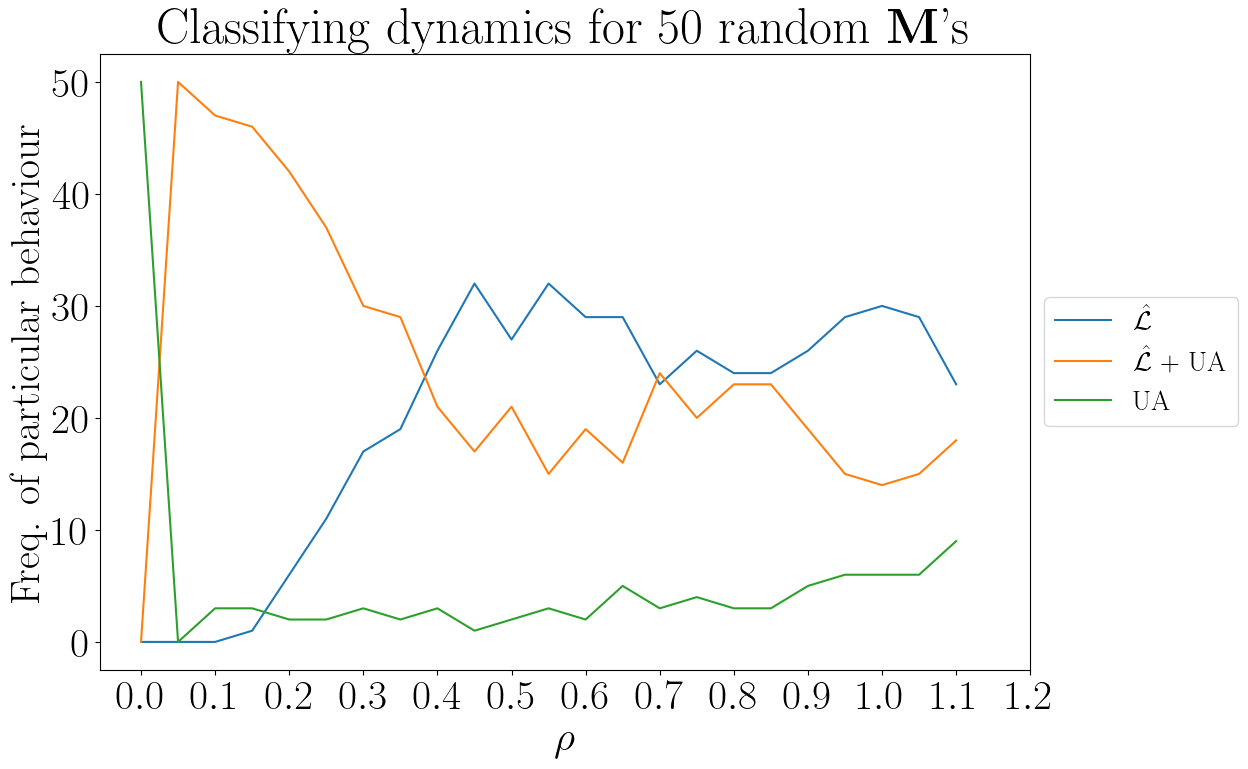

In [ ]:
# this cell plots a frequenxy graph as seen in experiment (1) section 5.1 that represents the number of explorations from the variants of a given type against rho
p_values = list(general_dict.keys())  # Assuming p is a list of values here

plt.figure(figsize=(12, 8))

# Plotting each unique key against p
for i, unique_key in enumerate(trimmed_keys):
    counts = [general_dict[p][unique_key] for p in p_values]
    if i < 10:
      plt.plot(spectral_radii_float, counts, label=unique_key)
    else:
      plt.plot(spectral_radii_float, counts, label=unique_key, ls = "--")


# Add labels and legend
plt.xlabel('$\\rho$')
plt.ylabel('Freq. of particular behaviour')
plt.title(r"Classifying dynamics for 50 random $\mathbf{M}$'s")
plt.xticks(np.arange(min(spectral_radii_float), max(spectral_radii_float) + 0.1, 0.1))
plt.legend(fontsize = 20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'drive/My Drive/bifurcation_analysis_data_pictures/Experiment_1_M_basin_of_TA_VS_UA_global_state_space_for_0.0_to_1.10.pdf',transparent = True, bbox_inches = 'tight')

# Show plot
plt.show()

# Lorenz orientation follows the orientation of the lorenz attractor. Why?
We have direct map from input to output - the UA is not from the RC's own dynamics it is a confabulation. it has some resemblance to the lorenz for instance the direction of flow on the attractors wings is preserved.

Find maximum index of attractor and check if the direction along x is decreasing and y is decreasing for all. check if the orientation of it is the same as the

In [ ]:
# max = findmax(traj)
# store max - max+1, max+2- max +3
# if all storedmax == same thing and flow of stored max is homeomorphic

In [ ]:
#load alltrajectories for rho
# find orientation of maximum flow point in lorenz and check if the trajectory at that point follows a given flow direction.
# do this for each entry in rho_M
# if all vectors for orientation away from maximum are equivalent then we say this is proeserved orientation.
def get_global_maxima_along_axis(traj, axis):
  local_maxima = []
  for i in range(1, len(traj) - 1):
      window = traj[i-1:i+2]
      middle_point = traj[i]
      # Find the local maxima in terms of the x coordinate.
      if middle_point[axis] == max(window[0][axis], window[1][axis], window[2][axis]):
          #print(i)
          local_maxima.append((i, middle_point))

      # Find the global maximum.
      max_value = float('-inf')
      global_max_index = None
      for index, state in local_maxima:
          # Check if the current state's third value is greater than the current maximum
          if state[axis] > max_value:
              #print(str(index) +" has "+ str(state) + " > " + str(max_value))
              max_value = state[axis]
              global_max_index = index
      global_max_state = traj[global_max_index]

In [ ]:
# file_path1 = f'drive/My Drive/bifurcation_analysis_data/classifications_M_dict.pkl'
# file_path2 = f'drive/My Drive/bifurcation_analysis_data/classifications_Win_dict.pkl'

In [ ]:
spectral_radii_float = list(map(float, spectral_radii))

# Cells that plot the average percentage of ICs tending towards the trained attractor , and the untrained attractors as rho changes

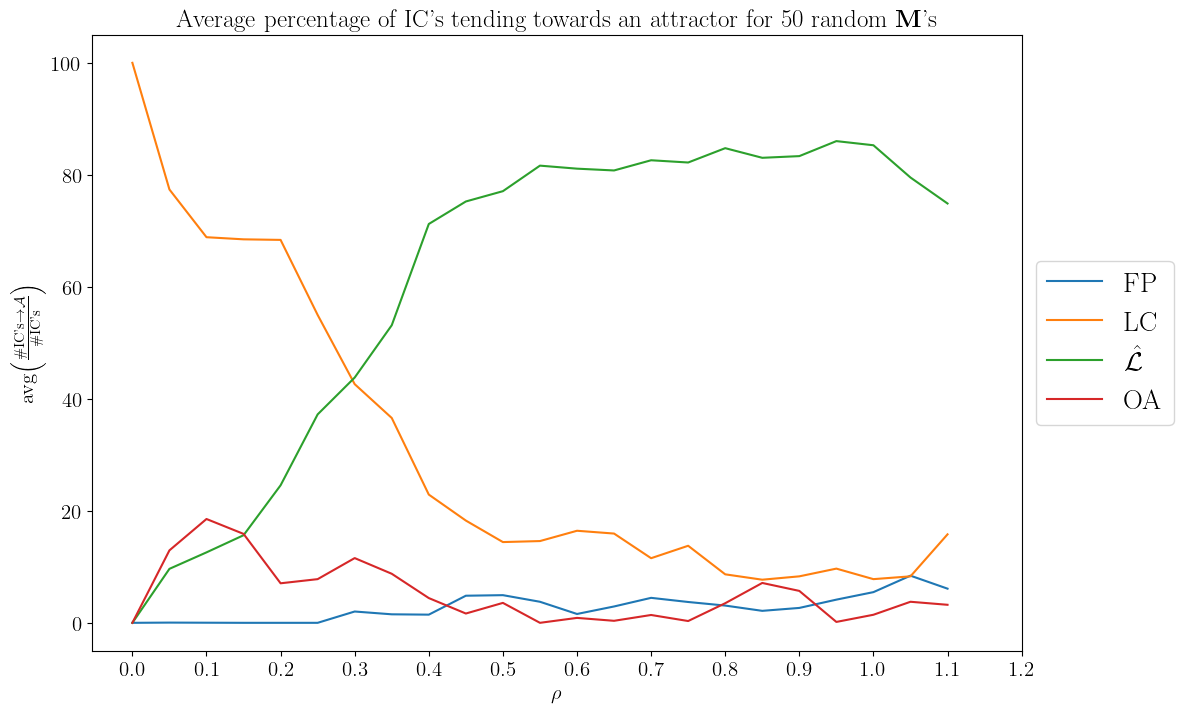

In [ ]:
attractor_distribution_dictionary = {}
for spectral_radius, list_containing_a_classification_lists_foreach_matrix_reshuffle  in bifurcation_analysis_attractor_data_M.items():
    # compile a list of classifications for every trajectory in every experiment into one
    all_classifications = [c for c_list in list_containing_a_classification_lists_foreach_matrix_reshuffle for c in c_list]
    # get counts of the occurence of each value of classification
    unique, counts = np.unique(all_classifications, return_counts=True)
    # stich the counts and the element associated together to form a dictionary of value and recurrence
    attractor_distribution = dict(zip(unique, counts))
    # add this count for this spectral_radius to the tracking dictionary for later use.
    if spectral_radius not in spectral_radius:
      attractor_distribution_dictionary[spectral_radius] = {}
    attractor_distribution_dictionary[spectral_radius] = attractor_distribution
    #print(f"Spectral Radius: {spectral_radius}, Attractor Distribution: {attractor_distribution}")


# Calculate percentages and plot
attractor_types = ["FP", "LC", "$\hat{\mathcal{L}}$", "OA"]
plt.figure(figsize=(12, 8))

for attractor_type in range(4):
    attractor_counts = [attractor_distribution_dictionary.get(r,0).get(attractor_type, 0) for r in spectral_radii]
    total_trajectories = [sum(attractor_distribution_dictionary[r].values()) for r in spectral_radii]
    attractor_percentages = [count / total * 100 if total != 0 else 0 for count, total in zip(attractor_counts, total_trajectories)]
    plt.plot(spectral_radii_float, attractor_percentages, label=attractor_types[attractor_type])

plt.xlabel('$\\rho$')
plt.ylabel(r"avg$\left(\frac{\# \text{IC's} \rightarrow \mathcal{A}}{\# \text{IC's}}\right)$")
plt.title(r"Average percentage of IC's tending towards an attractor for 50 random $\mathbf{M}$'s")
plt.legend(fontsize = 20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(np.arange(min(spectral_radii_float), max(spectral_radii_float) + 0.1, 0.1))
#plt.show
plt.savefig(f'drive/My Drive/bifurcation_analysis_data_pictures/Percentage_Experiment_1_M_basin_of_TA_VS_UA_global_state_space_for_0.0_to_1.10.pdf',transparent = True, bbox_inches = 'tight')

# Hit rate of a given attractor.
The percentage of initial conditions that lie in the basin of attraction of a particular attractor across all simulations. - $P_{\text{ic}}(\rho)$

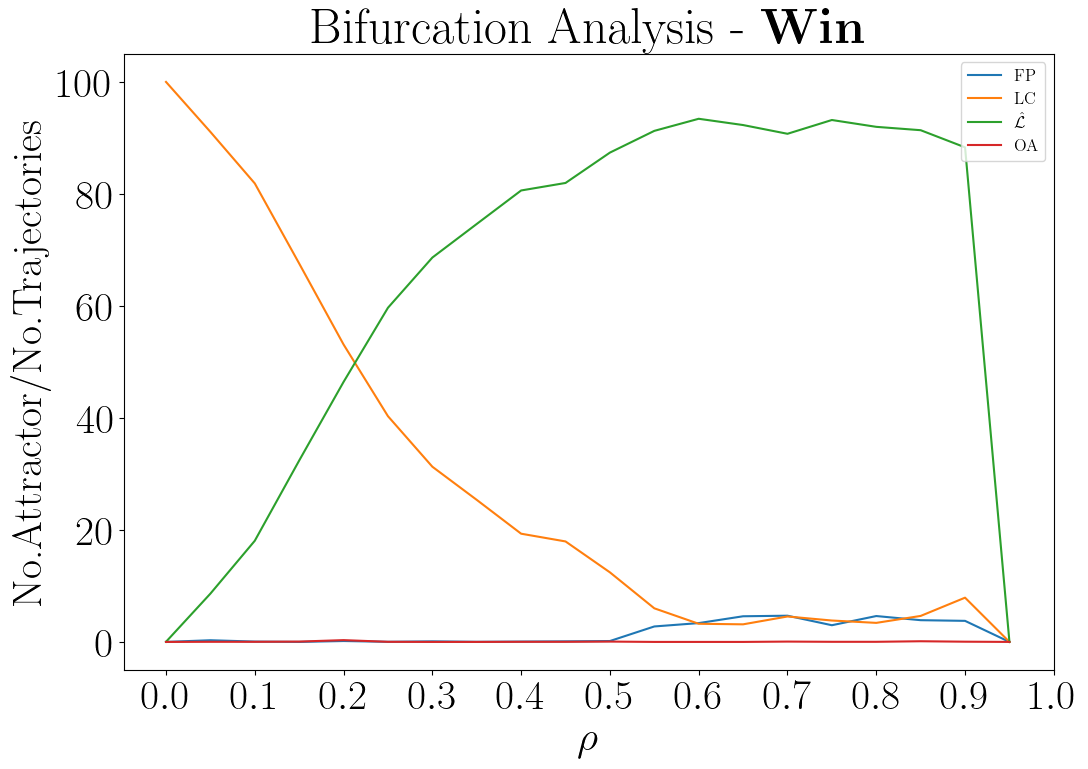

In [ ]:
attractor_distribution_dictionary = {}
for spectral_radius, list_containing_a_classification_lists_foreach_matrix_reshuffle  in bifurcation_analysis_attractor_data_Win.items():
    # compile a list of classifications for every trajectory in every experiment into one
    all_classifications = [c for c_list in list_containing_a_classification_lists_foreach_matrix_reshuffle for c in c_list]
    # get counts of the occurence of each value of classification
    unique, counts = np.unique(all_classifications, return_counts=True)
    # stich the counts and the element associated together to form a dictionary of value and recurrence
    attractor_distribution = dict(zip(unique, counts))
    # add this count for this spectral_radius to the tracking dictionary for later use.
    if spectral_radius not in spectral_radius:
      attractor_distribution_dictionary[spectral_radius] = {}
    attractor_distribution_dictionary[spectral_radius] = attractor_distribution
    #print(f"Spectral Radius: {spectral_radius}, Attractor Distribution: {attractor_distribution}")


# Calculate percentages and plot
attractor_types = ["FP", "LC", "$\hat{\mathcal{L}}$", "OA"]
plt.figure(figsize=(12, 8))

for attractor_type in range(4):
    attractor_counts = [attractor_distribution_dictionary.get(r,0).get(attractor_type, 0) for r in spectral_radii]
    total_trajectories = [sum(attractor_distribution_dictionary[r].values()) for r in spectral_radii]
    attractor_percentages = [count / total * 100 if total != 0 else 0 for count, total in zip(attractor_counts, total_trajectories)]
    plt.plot(spectral_radii_float, attractor_percentages, label=attractor_types[attractor_type])

plt.xlabel("$\\rho$")
plt.ylabel("No.Attractor/No.Trajectories")
plt.title("Bifurcation Analysis - $\mathbf{Win}$")
plt.legend(fontsize=12, loc='upper right')
plt.xticks(np.arange(min(spectral_radii_float), max(spectral_radii_float) + 0.1, 0.1))
plt.show()

Advanced attractor percentage classifications

In [ ]:
attractor_distribution_dictionary = {}

for spectral_radius, list_containing_classification_tuples in bifurcation_analysis_attractor_data_M.items():
    # Flatten the list of classifications for each reshuffle into one list
    all_classifications = [c for c_list in list_containing_classification_tuples for c in c_list]

    # Count the occurrences of each (attractor_type, instance_index)
    unique, counts = np.unique(all_classifications, return_counts=True, axis=0)

    # Create a dictionary mapping (attractor_type, instance_index) -> count
    attractor_distribution = {tuple(u): c for u, c in zip(unique, counts)}

    # Store the distribution for this spectral radius
    attractor_distribution_dictionary[spectral_radius] = attractor_distribution

# Plotting the results
plt.figure(figsize=(12, 8))

# Get unique attractor instances from global_attractor_dict
attractor_instances = [(cls, instance_id) for cls, instances in global_attractor_dict.items() for instance_id, _ in enumerate(instances, 1)]

# Calculate and plot the percentage of trajectories for each attractor instance
for attractor_instance in attractor_instances:
    attractor_counts = [attractor_distribution_dictionary.get(r, {}).get(attractor_instance, 0) for r in spectral_radii]
    total_trajectories = [sum(attractor_distribution_dictionary[r].values()) for r in spectral_radii]

    # Calculate percentage of trajectories that belong to this attractor instance
    attractor_percentages = [count / total * 100 if total != 0 else 0 for count, total in zip(attractor_counts, total_trajectories)]

    # Plot each attractor instance as a separate line
    label = f"Attractor {attractor_instance[0]}, Instance {attractor_instance[1]}"
    plt.plot(spectral_radii_float, attractor_percentages, label=label)

# Labeling and final touches for the plot
plt.xlabel("$\\rho$ (Spectral Radius)")
plt.ylabel("$P_{ic}(\\rho)$", rotation=0)
plt.title("Attractor Instances - $\mathbf{M}$")
plt.legend(fontsize=12, loc='upper right')
plt.xticks(np.arange(min(spectral_radii_float), max(spectral_radii_float) + 0.1, 0.1))
plt.tight_layout()
plt.show()